In [3]:
import numpy as np
from scipy.stats import linregress
from scipy.optimize import minimize
import pandas as pd
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
# These lines do some fancy plotting magic.s
%matplotlib inline
import matplotlib.pyplot as plt
import plotnine as p9
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [4]:
"""
 A. Model equation using a logistic regression model is: 
 'bwt' = 0.0563  - 0.017 (lwt) +  1.32 (black) + 0.93 (other) + 1.03 (smoke)
 + 1.87 (ht) +  0.72 (ui)
 B. Shown below 
 C. 0.3 appears to be the threshold I choose. 
 D. I got a 67% accuracy. 
 E. The baseline accuracy is 31%. Therefore, we see that our confusion matrix 
 is higher and therefore more accurate and thus, showing that logistic modeling 
 is well-equipped to increasing the accuracy. 
 g. The AUC of the classifier is 0.73
    

"""

"\n A. Model equation using a logistic regression model is: \n 'bwt' = 0.0563  - 0.017 (lwt) +  1.32 (black) + 0.93 (other) + 1.03 (smoke)\n + 1.87 (ht) +  0.72 (ui)\n B. Shown below \n C. 0.3 appears to be the threshold I choose. \n D. I got a 67% accuracy. \n E. The baseline accuracy is 31%. Therefore, we see that our confusion matrix \n is higher and therefore more accurate and thus, showing that logistic modeling \n is well-equipped to increasing the accuracy. \n g. The AUC of the classifier is 0.73\n    \n\n"

In [14]:
# q1 p.a 
birthwt = pd.read_csv("Downloads/birth.csv")
birthwt = birthwt.drop(columns='Unnamed: 0')
race_dummies = pd.get_dummies(birthwt["race"], prefix="race")
# add the indicator variables to the original dataset
birthwt = pd.concat([birthwt, race_dummies], axis=1)

# drop the original "race" column and the "race_other" dummy variable
birthwt.drop(["race"], axis=1, inplace=True) 
birthwt = birthwt.rename(columns= {'race_1': 'white', 'race_2': 'black', 'race_3': 'other'}) # 1 for that race, 0 for false 
birthwt.head(10)

,low,age,lwt,smoke,ptl,ht,ui,ftv,bwt,white,black,other
0,0,19,182,0,0,0,1,0,2523,0,1,0
1,0,33,155,0,0,0,0,3,2551,0,0,1
2,0,20,105,1,0,0,0,1,2557,1,0,0
3,0,21,108,1,0,0,1,2,2594,1,0,0
4,0,18,107,1,0,0,1,0,2600,1,0,0
5,0,21,124,0,0,0,0,0,2622,0,0,1
6,0,22,118,0,0,0,0,1,2637,1,0,0
7,0,17,103,0,0,0,0,1,2637,0,0,1
8,0,29,123,1,0,0,0,1,2663,1,0,0
9,0,26,113,1,0,0,0,0,2665,1,0,0


In [15]:
x = birthwt[['lwt', 'black', 'other', 'smoke', 'ht', 'ui']]
y = birthwt['low']
X = sm.add_constant(x)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.540256
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                  0.1298
Time:                        10:39:12   Log-Likelihood:                -102.11
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 3.220e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0563      0.938      0.060      0.952      -1.782       1.894
lwt           -0.0167      0.

In [16]:
thresholds = np.arange(0, 1.05, 0.05)
X = birthwt[['lwt', 'white', 'other', 'smoke', 'ht', 'ui']]
X = sm.add_constant(X)
y = birthwt['low']
model = sm.Logit(y, X).fit()
results = []
for threshold in thresholds:
    y_pred = (model.predict(X) >= threshold).astype(int)
    accuracy = np.mean(y_pred == y)
    sensitivity = np.sum((y_pred == 1) & (y == 1)) / np.sum(y == 1)
    specificity = np.sum((y_pred == 0) & (y == 0)) / np.sum(y == 0)
    results.append([threshold, accuracy, sensitivity, specificity])
results = pd.DataFrame(results, columns=['threshold', 'accuracy', 'sensitivity', 'specificity'])
print(results)


Optimization terminated successfully.
         Current function value: 0.540256
         Iterations 6
    threshold  accuracy  sensitivity  specificity
0        0.00  0.312169     1.000000     0.000000
1        0.05  0.333333     1.000000     0.030769
2        0.10  0.417989     0.983051     0.161538
3        0.15  0.507937     0.949153     0.307692
4        0.20  0.513228     0.864407     0.353846
5        0.25  0.571429     0.813559     0.461538
6        0.30  0.682540     0.711864     0.669231
7        0.35  0.682540     0.491525     0.769231
8        0.40  0.714286     0.423729     0.846154
9        0.45  0.724868     0.406780     0.869231
10       0.50  0.730159     0.355932     0.900000
11       0.55  0.740741     0.322034     0.930769
12       0.60  0.730159     0.237288     0.953846
13       0.65  0.724868     0.152542     0.984615
14       0.70  0.703704     0.084746     0.984615
15       0.75  0.693122     0.033898     0.992308
16       0.80  0.693122     0.016949     1.00000

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score 
threshold = 0.3
model = LogisticRegression().fit(X, y)
y_prob = model.predict_proba(X)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y, y_pred)
print(cm)


[[80 50]
 [14 45]]


In [18]:
# q1. d
from sklearn.metrics import accuracy_score
acc = accuracy_score(y, y_pred)
print(acc)

0.6613756613756614


In [19]:
# q1.e 
sum(birthwt['low'])/ len(birthwt)
# baseline accuracy

0.31216931216931215

In [27]:

fpr, tpr, thresholds = roc_curve(birthwt['low'], model.predict_proba(x)[:, 1])
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle= "--", label= 'Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.title('ROC curve for logistic regression classifier')
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- black
Feature names seen at fit time, yet now missing:
- const
- white


In [ ]:
logreg = LogisticRegression()
logreg.fit(x, y)
y_true = birthwt['low']
y_prob = logreg.predict_proba(x)[:, 1]

auc = roc_auc_score(y_true, y_prob)
print("AUC:", auc)


AUC: 0.7314211212516297


In [ ]:
"""
Question 2
a. 57 rows are include in the test set. 
d. There are 5 coefficients in the model. The most important one is ui in this case
with the highest absolute value. 
e. To maximize the AUC of the rest the test set, we would need a threshold of 0.5. 
f. In our case, there is only a one variable / coefficient difference (no black coefficient)
between these two approaches. Because Lasso penalizes the coefficients, this form of generalization
would have better performance as opposed to the iterative approach of backwards model
selection. 
"""

'\nQuestion 2\n\n'

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
print(f"Number of rows in the test set: {X_test.shape[0]}")

NameError: name 'train_test_split' is not defined

In [ ]:
X_train_pp = pd.DataFrame(scaler.transform(X_train), columns = [['lwt', 'black', 'other', 'smoke', 'ht', 'ui']])
X_test_pp = pd.DataFrame(scaler.transform(X_test), columns = [['lwt', 'black', 'other', 'smoke', 'ht', 'ui']])

model2 = LogisticRegression(penalty='l1', solver = 'liblinear', C = 0.2)
model2.fit(X_train_pp, y_train)
print(model2.coef_)

[[-0.12960164  0.          0.09260209  0.22124667  0.08263585  0.32083876]]


In [12]:
# q2. part b 
coefs_lasso = pd.DataFrame()
auc_list = []
Cs = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1]

for threshold in Cs:
    model = LogisticRegression(penalty='l1', solver = 'liblinear', C=threshold)
    tempmodel = model.fit(X_train_pp, y_train)
    coefs_lasso = pd.concat([coefs_lasso, pd.Series(tempmodel.coef_[0]).to_frame().T], ignore_index= True)
    pred = tempmodel.predict(X_test_pp)
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
    auc_list.append(auc(fpr, tpr))

NameError: name 'X_train_pp' is not defined

In [ ]:
lasso_plt = coefs_lasso
lasso_plt.rename(columns={0: 'lwt', 1: 'black',
                                2: 'other', 3: 'smoke',
                                4: 'ht', 5: 'ui'}, inplace = True)
lasso_plt['Threshold'] = Cs

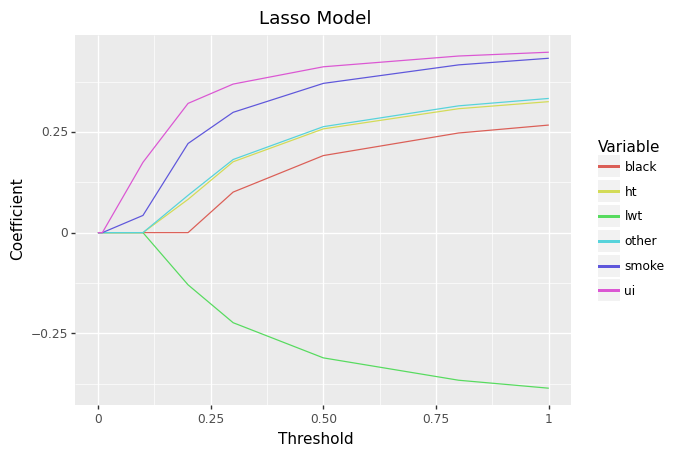

<ggplot: (8784994844769)>

In [ ]:
#q2 part c
lasso_plt_mlt = pd.melt(lasso_plt, id_vars = 'Threshold',
                                  var_name = 'Variable', value_name = 'Coefficient')
(p9.ggplot(lasso_plt_mlt, p9.aes(x = 'Threshold', y = 'Coefficient',
                                            color = 'Variable')) + p9.geom_line())

In [ ]:
# q2 part d
plt_label = lasso_plt_mlt[(lasso_plt_mlt['Threshold'] == 0.2)]
print(plt_label)

    Threshold Variable  Coefficient
4         0.2      lwt    -0.129557
13        0.2    black     0.000000
22        0.2    other     0.092628
31        0.2    smoke     0.221272
40        0.2       ht     0.082620
49        0.2       ui     0.320843


In [ ]:
# q2. part e

for threshold in Cs:
    model = Lasso(alpha=threshold, max_iter= 100000, random_state=42)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_train_scaler)
    auc = roc_auc_score(y_train, y_predicted)
    print(f"{threshold}: {auc}")

NameError: name 'Cs' is not defined

In [ ]:
Cs[np.argmax(auc_list)]


0.5